In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from itertools import product
import seaborn as sns

from functools import partial
tqdm = partial(tqdm, position=0, leave=True)


In [2]:
class model(nn.Module):
    def __init__(self, model_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, int(2.3 * model_size), 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(int(2.3 * model_size), int(3 * model_size), 5)
        self.fc1 = nn.Linear(int(3 * model_size) * 4 * 4, int(30 * model_size)) 
        self.fc2 = nn.Linear(int(30 * model_size), int(10 * model_size))
        self.fc3 = nn.Linear(int(10 * model_size), 10)
        self.dropout = nn.Dropout(0.1)
        self.batch_norm_conv1 = nn.BatchNorm2d(int(2.3 * model_size))
        self.batch_norm_conv2 = nn.BatchNorm2d(int(3 * model_size))
        self.batch_norm1 = nn.BatchNorm1d(int(30 * model_size))
        self.batch_norm2 = nn.BatchNorm1d(int(10 * model_size))
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch_norm_conv1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm_conv2(x)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = F.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.fc3(x)
        return x

In [3]:
def evaluate(testloader, net, criterion):
    with torch.no_grad():
        running_loss = 0
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss

In [4]:
def train_one_epoch(model_size, data_size, device, train_loader, test_loader):
  # Make Net and Loss Function
  net = model(model_size)
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  rate = 0.01 / np.sqrt(model_size)
  optimizer = optim.Adam(net.parameters(), lr=rate, betas=(0.9, 0.98), eps=1e-9)

  for i, data in tqdm(enumerate(train_loader)):
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad(set_to_none=True)
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      if i > (data_size * data_augment * 60000) / batch_size:
          break

  net.eval()
  eval_loss = evaluate(test_loader, net, criterion)
  print(eval_loss)
  return eval_loss

In [8]:
def MNIST_dataloaders(data_augment, batch_size):
    '''
    Creates and returns dataloaders for the train and test MNIST datasets. data_augment controls how many copies of the dataset is included 
    in the training dataloader. The training data is randomly distorted and rotated, so even with large data_augment factors, exact copies 
    in the trianing data are unlikely.
    '''
    # Load Training Data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
    augment = transforms.Compose([transforms.RandomRotation(10), transforms.RandomPerspective(distortion_scale=.2),
                                  transforms.ToTensor(), transforms.Normalize(0, 1)])
    trainset = [torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                             transform=augment) for i in range(data_augment)]                       
    trainset = torch.utils.data.ConcatDataset(trainset)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=4, persistent_workers=True)
    # Load Eval Data
    test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2, persistent_workers=True)
    return train_loader, test_loader

In [117]:
# DataFrame for storing eval performance for the different model sizes and data sizes.
new_df = pd.DataFrame({'data_size': [], 'model_size': [], 'eval_loss': [], 'compute': []})

In [ ]:
if __name__ == '__main__':

    batch_size = 256

    num_trials = 10
    
    model_size_list = [math.sqrt(2) ** i for i in range(9)]
    data_size_list = [1 / i for i in model_size_list]
    test_combos = list(product(model_size_list, data_size_list))
    
    data_augment = 32

    device = 'cuda'

    train_loader, test_loader = MNIST_dataloaders(data_augment, batch_size)
    
    for test in range(num_trials):
        for model_size, data_size in tqdm(test_combos):
            eval_loss = train_one_epoch(model_size, data_size, device, train_loader, test_loader)
            new_df.loc[len(new_df.index)] = [data_size, model_size, eval_loss, (model_size**2 * data_size)]

In [6]:
new_df = pd.read_csv('df.csv')
new_df

,Unnamed: 0,data_size,model_size,eval_loss,compute
0,0,1.00,1.0,3.75,1.00
1,1,0.71,1.0,4.38,0.71
2,2,0.50,1.0,5.10,0.50
3,3,0.35,1.0,6.09,0.35
4,4,0.25,1.0,6.75,0.25
...,...,...,...,...,...
481,481,0.25,16.0,1.69,64.00
482,482,0.18,16.0,1.61,45.25
483,483,0.12,16.0,1.55,32.00
484,484,0.09,16.0,2.33,22.63


(0.0, 6.0)

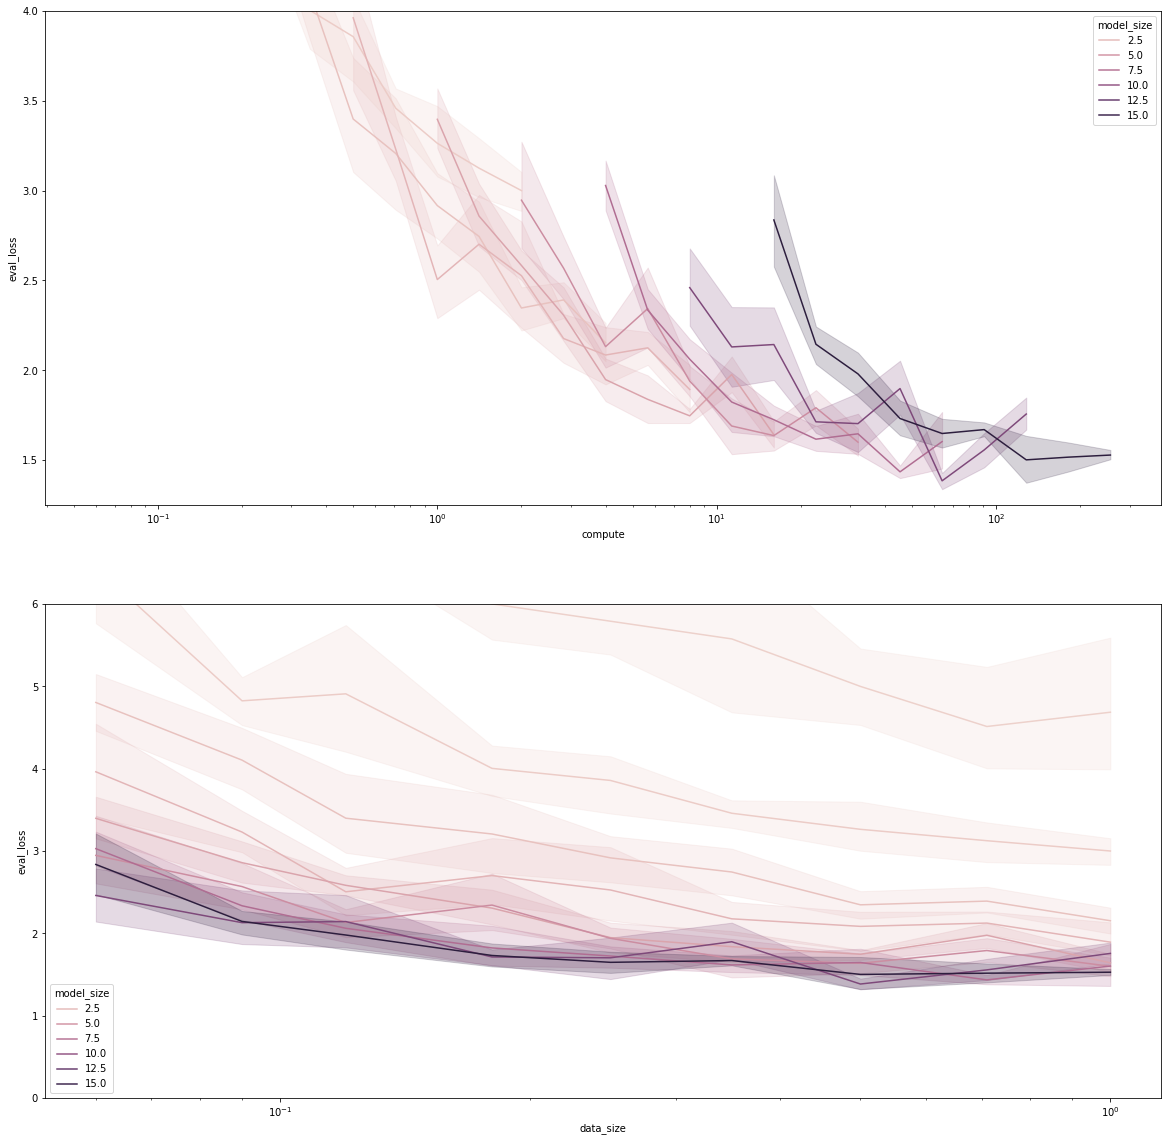

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20, 20))
ax = ax.flatten()

sns.lineplot(data=df, x = 'compute', y='eval_loss', hue='model_size', ci=80, ax=ax[0])
sns.lineplot(data=df, x = 'data_size', y='eval_loss', hue='model_size', ci=95, ax=ax[1])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylim(1.25, 4)
ax[1].set_ylim(0, 6)

In [121]:
df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

cp: cannot create regular file 'drive/My Drive/': No such file or directory
